In [1]:
import netCDF4
import xarray as xr
from rasterio.warp import reproject, Resampling

# canopy height data: from NetCDF to Zarr

The canopy height dataset is provided as chunked NetCDF4/HDF5 data. It was reprojected and downloaded from GEE, and reprojected with ERA5Land in crib. It is only for Europe, need to download other area from GEE.

## Input variables

In [2]:
year = 2015

In [69]:
ROOT_DIR = '/gpfs/work2/0/ttse0619'
hc_PATH = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/canopy_height/canopy_height_11kmGlobal20240215.tif'
)
OUT_PATH = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/canopy_height/hc_global.zarr'
)

In [70]:
ERA5_PATH = (
    f'{ROOT_DIR}/francesco/Projects/EcoExtreML/Data/'
    f'1input_data/{year}global/era5land/era5land.zarr'
)

## Converting the dataset

We start by loading the ERA5-land Zarr dataset, which we will use as the target for reprojection: 

In [71]:
ds = xr.open_zarr(ERA5_PATH)

In [72]:
ds = ds.rio.write_crs('WGS84')
target = ds['sp'].isel(time=0, drop=True)

In [73]:
target

<xarray.DataArray 'sp' (latitude: 1801, longitude: 3600)>
dask.array<getitem, shape=(1801, 3600), dtype=float32, chunksize=(250, 250), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude    (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
    spatial_ref  int64 0
Attributes:
    long_name:      Surface pressure
    standard_name:  surface_air_pressure
    units:          Pa

In [74]:
# convert from [0,360] to [-180,180]
target['longitude'] = (target['longitude'] + 180) % 360 - 180
target = target.sortby(["longitude"])

In [75]:
target

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<xarray.DataArray 'sp' (latitude: 1801, longitude: 3600)>
dask.array<getitem, shape=(1801, 3600), dtype=float32, chunksize=(250, 250), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
    spatial_ref  int64 0
Attributes:
    long_name:      Surface pressure
    standard_name:  surface_air_pressure
    units:          Pa

In [76]:
hc_PATH

'/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/canopy_height/canopy_height_11kmGlobal20240215.tif'

We now open the landcover NetCDF files using the same chunking scheme as in the NetCDF file:

In [94]:
hc = xr.open_dataset(hc_PATH).band_data
hc = hc.squeeze('band')  # drop band dimension
hc = hc.sortby(["x", "y"])

In [95]:
hc

<xarray.DataArray 'band_data' (y: 1480, x: 3600)>
[5328000 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 -59.95 -59.85 -59.75 -59.65 ... 87.75 87.85 87.95
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    long_name:      b1

In [96]:
import numpy as np
hc.rio.write_nodata(np.nan, inplace=True)
hc = hc.rio.write_crs('EPSG:4326')
target = target.rio.write_crs('EPSG:4326')
hc_reprojected = hc.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan)
hc_reprojected = hc_reprojected.assign_coords({
    "x": hc_reprojected.x,
    "y": hc_reprojected.y,
})
# fix naming of coordinates
hc_reprojected = hc_reprojected.rename(
    x='longitude',
    y='latitude'
)
print(hc_reprojected)

<xarray.DataArray 'band_data' (latitude: 1801, longitude: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
    band         int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      b1
    _FillValue:     nan


In [97]:
hc_reprojected.mean()

<xarray.DataArray 'band_data' ()>
array(8.350085, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [98]:
# (-180;180) -> (0;360)
hc_reprojected = hc_reprojected.assign_coords(
    longitude=(hc_reprojected.longitude + 360) % 360,
    latitude=hc_reprojected.latitude
)#.sortby('longitude')

In [99]:
hc_reprojected

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<xarray.DataArray 'band_data' (latitude: 1801, longitude: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * longitude    (longitude) float32 180.0 180.1 180.2 ... 179.7 179.8 179.9
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
    band         int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      b1
    _FillValue:     nan

In [100]:
# roll array to reorder coordinates 
nroll = (hc_reprojected.longitude.values >= 180 ).sum()
hc_reprojected = hc_reprojected.roll(longitude=-nroll, roll_coords=True)

In [101]:
hc_reprojected.mean()


<xarray.DataArray 'band_data' ()>
array(8.350087, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [102]:
hc.mean().compute()

<xarray.DataArray 'band_data' ()>
array(8.341771, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [103]:
hc_reprojected = hc_reprojected.to_dataset(name='hc')

In [104]:
hc_reprojected = hc_reprojected.chunk(
    longitude=250, 
    latitude=250
)
hc_reprojected.to_zarr(OUT_PATH, mode='w')

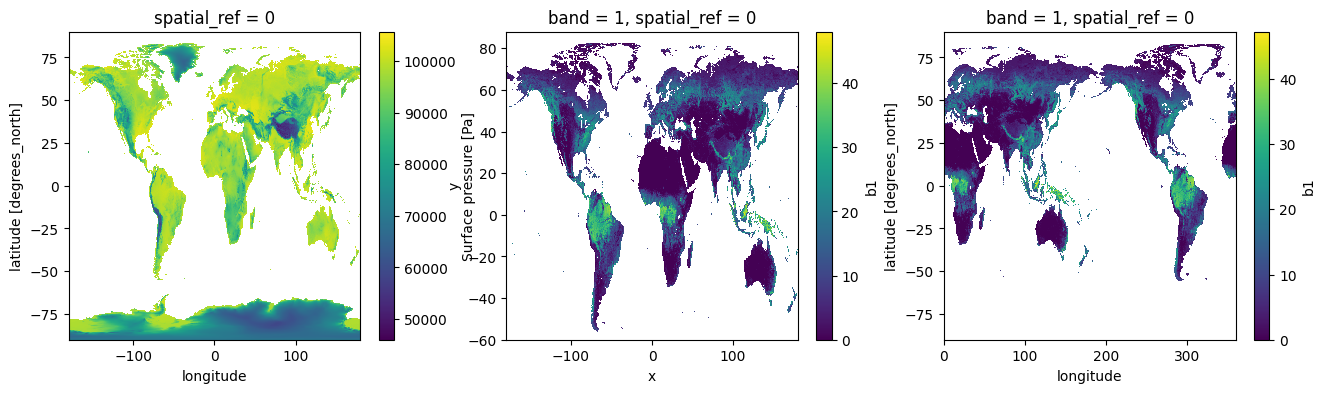

In [105]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

target.plot(ax=axes[0])
hc.plot(ax=axes[1])
hc_reprojected.hc.plot(ax=axes[2])
plt.draw()